## Uso de Decision Trees para mostrar explicação de decisões via regras derivadas dos ramos da DT.

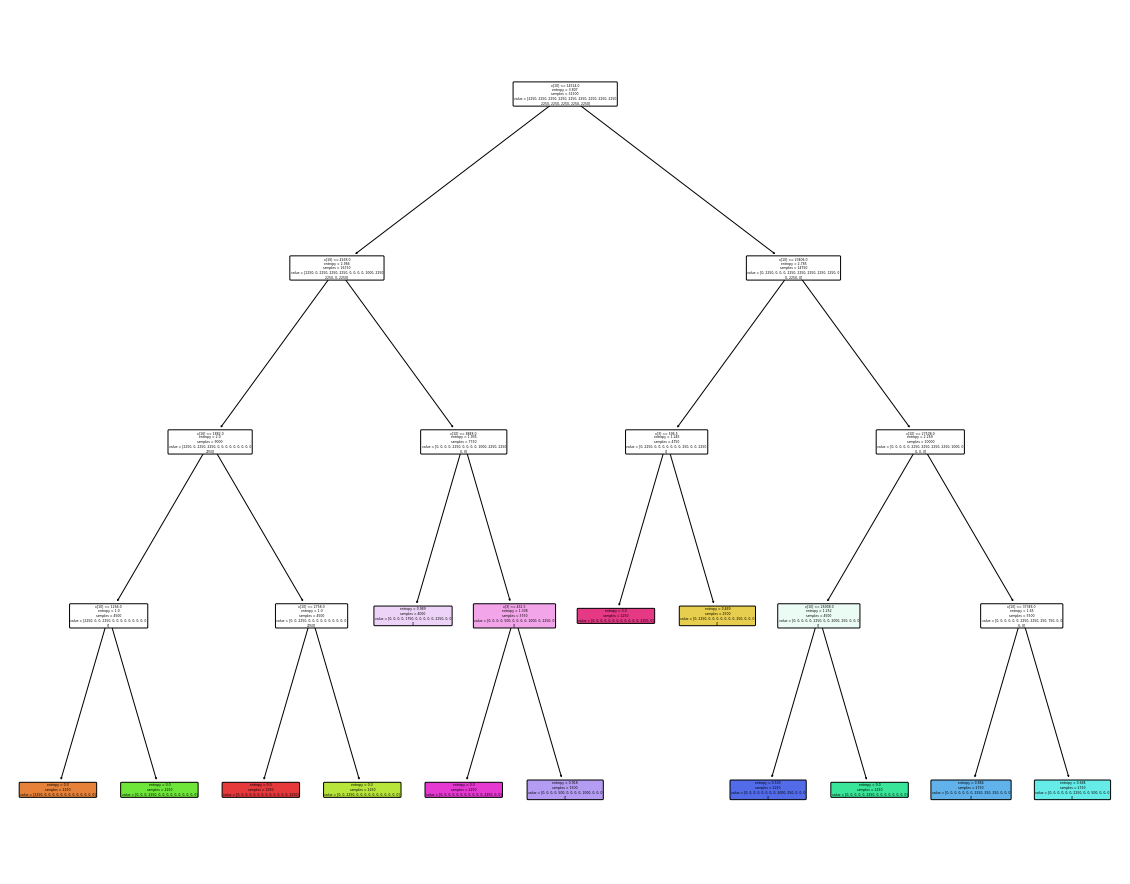

In [1]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

file_name = '../measurements.csv'
df = pd.read_csv(file_name, header=0, delimiter=",", decimal=".")

replace_map = {
    'Program': {
        'BubbleSort ': 0,
        'QuickSort ': 1,
        'SelectionSort ': 2
    }
}

replace_map2 = {'Language': {
                    'C ':0 ,
                    'Python Interpreted ': 1, 
                    'Python Compilled ': 2,
                    'Haskell ':3,
                    'Java ':4,
                    'C++ ':5,
                    'Prolog ':6,
                    'Ruby ':7,
                    'PHP ':8,
                    'Kotlin ':9,
                    'JavaScript ':10,
                    'C# ':11,
                    'Rust ':12,
                    'Go ':13
                    }}

y = df["Language"]
x = df.drop(columns=['Language'])
x.replace(replace_map, inplace=True)


clf = tree.DecisionTreeClassifier(random_state=2023, criterion='entropy', ccp_alpha=0.1)

plt.figure(figsize=(20, 16))
clf = clf.fit(x, y)
tree.plot_tree(clf, filled=True, rounded=True)
plt.show()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [3]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=2023)

In [4]:
clf = DecisionTreeClassifier(random_state=2023)
clf = clf.fit(x_train,y_train)

In [5]:
predictions_train = clf.predict(x_train)
predictions_test = clf.predict(x_test)

In [6]:
print("Classification report for training data")
print(classification_report(y_train, predictions_train))
print("\nClassification report for test data")
print(classification_report(y_test, predictions_test))

Classification report for training data
                     precision    recall  f1-score   support

                 C        1.00      1.00      1.00      1714
                C#        1.00      1.00      1.00      1695
               C++        1.00      1.00      1.00      1689
                Go        1.00      1.00      1.00      1691
           Haskell        1.00      1.00      1.00      1698
              Java        1.00      1.00      1.00      1648
        JavaScript        1.00      1.00      1.00      1687
            Kotlin        1.00      1.00      1.00      1693
               PHP        1.00      1.00      1.00      1688
            Prolog        1.00      1.00      1.00      1699
  Python Compilled        1.00      1.00      1.00      1712
Python Interpreted        1.00      1.00      1.00      1707
              Ruby        1.00      1.00      1.00      1642
              Rust        1.00      1.00      1.00      1662

           accuracy                        

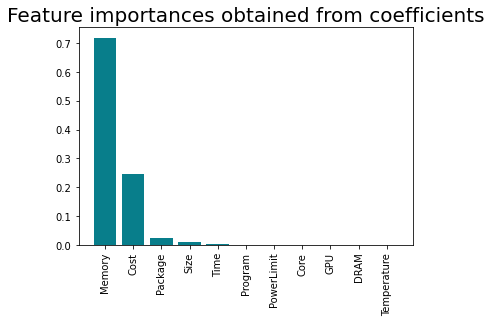

In [7]:
# Feature importance
clf.fit(x_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': clf.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [8]:
y = df["Language"]
x = df.drop(columns=['Language', 'Temperature', 'DRAM', 'GPU', 'Core', 'PowerLimit'])
x.replace(replace_map, inplace=True)

x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=2023)

x_test

,Program,Size,Cost,Package,Time,Memory
28587,1,5000,968,1.655029,121,29388
912,0,1000,514,0.208801,41,9188
15237,1,2500,328,0.059570,10,6800
24437,2,5000,680,2.014221,244,24540
423,2,1000,237,0.075317,24,5652
...,...,...,...,...,...,...
3369,1,1000,968,0.216125,28,24636
19543,0,2500,632,0.683228,60,27220
31459,2,5000,491,0.542236,40,1776
15181,0,2500,444,1.382629,127,10936


### Tuning

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [0.05, 0.1, 0.2]}

grid_search = GridSearchCV(clf, param_grid, cv=10)

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

predictions_train = grid_search.predict(x_train)
predictions_test = grid_search.predict(x_test)

print("Classification report for training data")
print(classification_report(y_train, predictions_train, zero_division=1))
print("\nClassification report for test data")
print(classification_report(y_test, predictions_test, zero_division=1))

Best parameters: {'max_depth': 9, 'min_samples_leaf': 0.05}
Best score: 0.9144119958304412
Classification report for training data
                     precision    recall  f1-score   support

                 C        1.00      1.00      1.00      1714
                C#        1.00      1.00      1.00      1695
               C++        1.00      1.00      1.00      1689
                Go        1.00      1.00      1.00      1691
           Haskell        0.94      0.66      0.78      1698
              Java        1.00      1.00      1.00      1648
        JavaScript        1.00      1.00      1.00      1687
            Kotlin        0.82      1.00      0.90      1693
               PHP        1.00      0.89      0.94      1688
            Prolog        1.00      0.00      0.00      1699
  Python Compilled        0.90      1.00      0.95      1712
Python Interpreted        0.54      1.00      0.70      1707
              Ruby        0.81      1.00      0.90      1642
              

### Previsão da linguagem dados alguns valores com o modelo treinado

In [10]:
# Assuming you have already defined the variables:
Program = "QuickSort "
Size = 0.25
Cost = 1000
Package = 1.05
Time = 10
Memory = 2000

# Create a dictionary with the input data
input_data = {
    'Program': [replace_map['Program'][Program]],
    'Size': [Size],
    'Cost': [Cost],
    'Package': [Package],
    'Time': [Time],
    'Memory': [Memory]
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(input_data)

# Extract the feature columns (x) from the input DataFrame
x = input_df[["Program", "Size", "Cost", "Package", "Time", "Memory"]]

# Make predictions for the input data
prediction = grid_search.predict(x)

# Retrieve the inferred value of "Language"
inferred_language = prediction[0]

print("Inferred Language:", inferred_language)


Inferred Language: Rust 
